In [1]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt

In [2]:
path = ['/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_', '/light_emission/output/']

p_xt = [0.05, 0.08, 0.15, 0.25]
files = ['ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz', 'ff-1m_r_2nphot_6000000_dist_500_radius_150_event.simtel.gz',
         'ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz', 'ff-1m_r_3nphot_14000000_dist_500_radius_150_event.simtel.gz',
         'ff-1m_r_2nphot_20000000_dist_500_radius_150_event.simtel.gz', 'ff-1m_r_4nphot_50000000_dist_500_radius_150_event.simtel.gz', 
         'ff-1m_r_3nphot_100000000_dist_500_radius_150_event.simtel.gz', 'ff-1m_r_4nphot_200000000_dist_500_radius_150_event.simtel.gz', 
         'ff-1m_r_5nphot_400000000_dist_500_radius_150_event.simtel.gz', 'ff-1m_r_5nphot_600000000_dist_500_radius_150_event.simtel.gz']

n_pe = ['2 p.e.', '5 p.e.', '10 p.e.', '100 p.e.', '200 p.e.', '500 p.e.']

output_dir = '/home/andrii/work/sim_telarray/charge_resolution/'

In [3]:
files

['ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_2nphot_6000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_3nphot_14000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_2nphot_20000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_4nphot_50000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_3nphot_100000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_4nphot_200000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_5nphot_400000000_dist_500_radius_150_event.simtel.gz',
 'ff-1m_r_5nphot_600000000_dist_500_radius_150_event.simtel.gz']

In [4]:
try:
    os.makedirs(output_dir, exist_ok=True)
    print("Directory ", output_dir, " Created ")
except FileExistsError:
    print("Directory ", output_dir, " already exists")

Directory  /home/andrii/work/sim_telarray/charge_resolution/  Created 


In [5]:
def plot_event(n_events, file):
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
        print(event.index)
        camgeom = source.subarray.tel[1].camera.geometry

        fig, (ax0, ax1) = plt.subplots(1, 2)
        disp0 = CameraDisplay(ax=ax0, geometry=camgeom)
        disp1 = CameraDisplay(ax=ax1, geometry=camgeom)

 
        title = "Sum of samples\n in waveforms : event {} ".format( int(event.index.event_id/100) )
        disp = CameraDisplay(ax=ax0, geometry=camgeom, title=title)
        disp.image = event.r0.tel[1].waveform[0].sum(axis=1)
        
        title = "True Image : event {} ".format( int(event.index.event_id/100 ))
        disp = CameraDisplay(ax=ax1, geometry=camgeom, title=title)
        disp.image = event.simulation.tel[1].true_image

        disp.cmap = plt.cm.viridis
        disp.add_colorbar()
        disp.set_limits_percent(95)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'diplay_r150_pe200_{}.png'.format(event.index.event_id)), dpi=800)



In [6]:
def get_n_pe(n_events, file):

    pe_true_map  = {}
    pe_true_map_mean = []

    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
    
        for pixel in range( len(event.r0.tel[1].waveform[0]) ):
        
            try:
                tmp_pe_list = pe_true_map[pixel]
                tmp_pe_list.append( event.simulation.tel[1].true_image[pixel] )
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_pe_list = [event.simulation.tel[1].true_image[pixel]]
            
            pe_true_map[pixel] = tmp_pe_list

    for i_pixel in range(len(pe_true_map)):
        pe_true_map_mean.append(np.mean(pe_true_map[i_pixel]))
        
    return pe_true_map, pe_true_map_mean

In [25]:
def get_n_pe_list(n_events, file):

    pe_true_map  = []
    pe_true_map_mean = []

    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    for event in source:
        pe_true_map.append(event.simulation.tel[1].true_image)
      
    pe_true_map_mean = np.mean(pe_true_map, axis = 0)
    return pe_true_map, pe_true_map_mean

In [33]:
pe_true_map_pxt_5, pe_true_map_mean_pxt_5 = get_n_pe_list(10000, path[0]+str(p_xt[0]) + path[1] + files[0])


In [35]:
len(pe_true_map_mean_pxt_5)

7987

In [64]:
def ana_waveforms(n_events, file):


    baseline_map  = {}
    amplitude_map = {}
    waveform_map = {}
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
        
        if(event%1000==0):
            print('ana_waveform, event : ', event)
    
        for pixel in range( len(event.r0.tel[1].waveform[0]) ):
        
            y = event.r0.tel[1].waveform[0][pixel]

            try:
                tmp_baseline_list = baseline_map[pixel]
                tmp_baseline_list.append(np.mean(y[:20]))
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_baseline_list = [np.mean(y[:20])]
            baseline_map[pixel] = tmp_baseline_list
        
        
            try:
                tmp_amplitude_list = amplitude_map[pixel]
                tmp_amplitude_list.append(np.amax(y))
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_amplitude_list = [np.amax(y)]
            amplitude_map[pixel] = tmp_amplitude_list
        
            try:
                tmp_waveform_list = waveform_map[pixel]
                tmp_waveform_list.append(event.r0.tel[1].waveform[0][pixel])
            except KeyError:
                #LOGGER.debug('Adding new module ID (%s) to the dictionary', module_id)
                tmp_waveform_list = [event.r0.tel[1].waveform[0][pixel]]
            
            waveform_map[pixel] = tmp_waveform_list       

    return baseline_map, amplitude_map, waveform_map


In [76]:
def ana_waveforms_v2(n_events, file, left_r, right_r):


    baseline  = []
    amplitude = []
    time = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)

    for event in source:
        
        y = event.r0.tel[1].waveform[0]
        y_trans = np.transpose(y)
        
        time_tmp = np.argmax(y_trans[left_r:right_r], axis = 0)
        baseline_tmp = np.mean(y_trans[:left_r], axis = 0)
        
        time.append(time_tmp)
        baseline.append(baseline_tmp)
        
        amplitude.append( np.max(y_trans[left_r:right_r], axis = 0) - baseline_tmp)
        

    baseline = np.transpose(baseline)
    amplitude = np.transpose(amplitude)
        
    return baseline, amplitude

In [137]:
pxt = p_xt[0]
baseline_map_pxt_5, amplitude_map_pxt_5 = ana_waveforms_v2(100, path[0]+str(p_xt[0]) + path[1] + files[0], 24, 30)

In [83]:
amplitude_map_pxt_5[0]

array([ 7.70833333,  0.79166667,  4.        , ..., 11.25      ,
        9.54166667,  5.625     ])

In [88]:
amplitude_map_pxt_5_cor = amplitude_map_pxt_5*(1. - pxt)

In [91]:
amplitude_map_pxt_5_cor[0]

array([ 7.32291667,  0.75208333,  3.8       , ..., 10.6875    ,
        9.06458333,  5.34375   ])

In [99]:
amplitude_map_pxt_5_cor_mean = np.mean(amplitude_map_pxt_5_cor, axis = 1)

In [101]:
amplitude_map_pxt_5_cor_mean

array([5.01258396, 5.03387187, 5.39197042, ..., 5.049345  , 4.9484075 ,
       4.88431021])

In [121]:
a = [amplitude_map_pxt_5_cor_mean]*10000
a = np.array(a).T

In [131]:
b = np.sum( (amplitude_map_pxt_5_cor - a)**2, axis=1)

In [148]:
c(b/9999)

array([3.46411338, 3.43533315, 3.65934132, ..., 3.44092008, 3.432945  ,
       3.3384178 ])

In [135]:
math.sqrt(b[0]/(9999))/amplitude_map_pxt_5_cor_mean[0]

0.6910833639963644

In [149]:
def calc_charge_resolution(n_events, file, pxt, baseline, amplitude):
    
    amplitude_corrected = []
    amplitude_mean = []
    std_list = []
    charge_resolution = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    xt = pxt
    xt_mean = xt/(1. - xt)
    
    amplitude_corrected = ( amplitude*(1 - xt_mean) )
    amplitude_mean = np.mean(amplitude_corrected, axis = 1)
    
    amplitude_mean_tmp = [amplitude_mean]*n_events
    amplitude_mean_tmp = np.array(amplitude_mean_tmp).T
    
    ampli_sum = np.sum( (amplitude_corrected - amplitude_mean_tmp)**2, axis=1)
    
    amplitude_std = np.sqrt(ampli_sum/(n_events-1))
    
    charge_resolution = amplitude_std/amplitude_corrected
    
    return charge_resolution

In [150]:
charge_resolution = calc_charge_resolution(100, path[0]+str(p_xt[0]) + path[1] + files[0], p_xt[0], baseline_map_pxt_5, amplitude_map_pxt_5)

ValueError: operands could not be broadcast together with shapes (7987,) (7987,100) 

In [79]:
print(np.mean(amplitude_map_pxt_5, axis = 1)[7000])

5.480383333333316


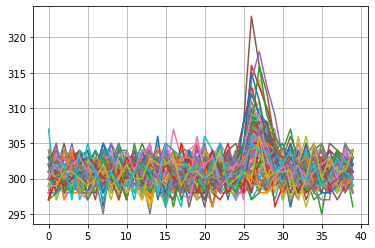

In [48]:
source = EventSource(path[0]+str(p_xt[0]) + path[1] + files[0], max_events=100, back_seekable=True)
seeker = EventSeeker(source)

for event in source:
    
    x = np.arange(0, len(event.r0.tel[1].waveform[0][0]),1)
    
    #for i_pixel in range(1):
    #print(event.r0.tel[1].waveform[0][0])
        
        #print( np.allclose( event.r0.tel[1].waveform[0][i_pixel], [304]*np.ones(len(event.r0.tel[1].waveform[0][0])), rtol = 0.1 ) )
    i_pixel = 10
    plt.plot(x, event.r0.tel[1].waveform[0][i_pixel], '-')
    
plt.grid(True)
#plt.xlim(0, 50)
plt.show()

In [65]:
def calc_charge_resolution(n_events, file, pxt, baseline_map, amplitude_map, waveform_map):
    
    baseline_list = []
    baseline_mean = []
    amplitude_list = []
    amplitude_corrected = []
    amplitude_corrected_mean = []
    waveform_list = []
    std_list = []
    charge_resolution = []
    
    source = EventSource(file, max_events=n_events, back_seekable=True)
    seeker = EventSeeker(source)
    
    xt = pxt
    xt_mean = xt/(1. - xt)


    for pixel in range( len(baseline_map) ):
        
        if(pixel%1000==0):
            print('calc_charge_resolution, pixel : ', pixel)
        
        baseline_list.append(baseline_map[pixel][:])
    
        baseline_mean.append(np.mean(baseline_list[pixel]))
    
        amplitude_list.append(amplitude_map[pixel][:])
    
        amplitude_corrected.append( (amplitude_list[pixel] - baseline_mean[pixel])*(1 - xt_mean) )
        amplitude_corrected_mean.append( np.mean(amplitude_corrected[pixel]) )
    
        waveform_list.append(waveform_map[pixel][:])
        std_list.append(0.)
    
        for event_id in range(len(baseline_map[pixel])):
            std_list[pixel] = std_list[pixel] + (amplitude_corrected[pixel][event_id] -  amplitude_corrected_mean[pixel])**2
    
        std_list[pixel] = std_list[pixel]/( len(baseline_map[pixel]) - 1)
        std_list[pixel] = math.sqrt(std_list[pixel])
    
        charge_resolution.append(std_list[pixel]/amplitude_corrected_mean[pixel])
    
    return charge_resolution

In [20]:
print(path[0]+str(p_xt[0]) + path[1] + files[2])

/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_0.05/light_emission/output/ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz


{'event_id': 100, 'obs_id': 1}


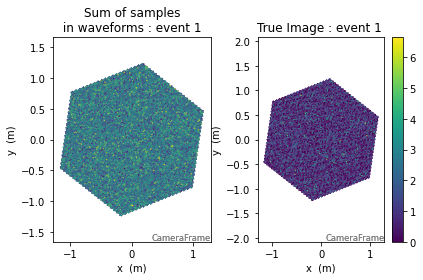

In [21]:
plot_event(1, path[0]+str(p_xt[0]) + path[1] + files[0])

In [22]:
pe_true_map, pe_true_map_mean = get_n_pe(100, path[0]+str(p_xt[0]) + path[1] + files[0])

In [23]:
print(pe_true_map[10])
print(pe_true_map_mean[10])

[0, 0, 1, 0, 2, 0, 1, 2, 3, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 3, 0, 4, 2, 1, 0, 1, 0, 2, 1, 2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 3, 0, 0, 0, 1, 0, 1, 1, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 1, 2, 2, 0, 2, 0, 1, 2, 1, 1, 1, 1, 3, 0, 3, 2, 1, 2, 2, 1, 0, 1, 3, 1, 0, 1, 0, 2, 1, 0, 0, 1]
1.04


In [24]:
baseline_map, amplitude_map, waveform_map = ana_waveforms(100, path[0]+str(p_xt[0]) + path[1] + files[0])

In [25]:
charge_resolution = calc_charge_resolution(100, path[0]+str(p_xt[0]) + path[1] + files[0], baseline_map, amplitude_map, waveform_map)

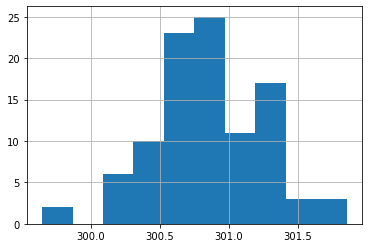

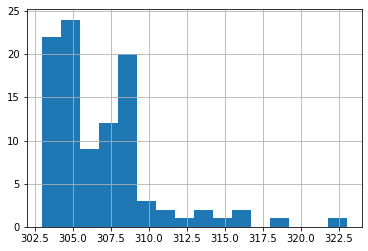

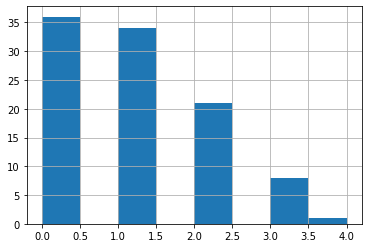

In [26]:
pixel_to_show = 10

plt.hist(baseline_map[pixel_to_show], bins='auto')
plt.grid(True)
plt.show()

plt.hist(amplitude_map[pixel_to_show], bins='auto')
plt.grid(True)
plt.show()

plt.hist(pe_true_map[pixel_to_show], bins='auto')
plt.grid(True)
plt.show()

In [27]:
baseline_map_pxt_5, amplitude_map_pxt_5, waveform_map_pxt_5 = ana_waveforms(100, path[0]+str(p_xt[0]) + path[1] + files[0])

In [28]:
pe_true_map_pxt_5, pe_true_map_mean_pxt_5 = get_n_pe(100, path[0]+str(p_xt[0]) + path[1] + files[0])

In [29]:
charge_resolution_pxt_5 = calc_charge_resolution(100, path[0]+str(p_xt[0]) + path[1] + files[0], baseline_map_pxt_5, amplitude_map_pxt_5, waveform_map_pxt_5)

In [45]:
def save_to_file(file_name, mean_pe, charge_resolution):
    
    file_object  = open(file_name, "w") 
    
    file_object.write("pixel \t mean p.e \t mean_charge_resolution \n")
    
    for line in range(len(mean_pe)):
        file_object.write("{} {:.18f} {:.18f}\n".format(line, mean_pe[line], charge_resolution[line]))
        
        
    file_object.close()
        

In [62]:
n_events = 10000
pxt = p_xt[0]

for item, i_file in enumerate(files):
    baseline_map_pxt_5[item], amplitude_map_pxt_5[item], waveform_map_pxt_5[item] = ana_waveforms(n_events, path[0]+str(pxt) + path[1] + i_file)
    pe_true_map_pxt_5[item], pe_true_map_mean_pxt_5[item] = get_n_pe(n_events, path[0]+str(pxt) + path[1] + i_file)
    charge_resolution_pxt_5[item] = calc_charge_resolution(n_events, path[0]+str(pxt) + path[1] + i_file, pxt, baseline_map_pxt_5[item], amplitude_map_pxt_5[item], waveform_map_pxt_5[item])
    
    out_xt_dir = output_dir +'/pxt_'+ str(pxt)
    try:
        os.makedirs(out_xt_dir, exist_ok=True)
        print("Directory ", out_xt_dir, " Created ")
    except FileExistsError:
        print("Directory ", out_xt_dir, " already exists")
    
    file_name = out_xt_dir + "/out_file_pxt_" + str(pxt) + "_" + i_file[:-15] + ".txt" 
    save_to_file(file_name, pe_true_map_mean_pxt_5[item], charge_resolution_pxt_5[item])
    
    print(i_file, ' charge resulution, average : ', np.mean(charge_resolution_pxt_5[item]))

KeyboardInterrupt: 

In [55]:
files[0][:-15]

'ff-1m_r_1nphot_2000000_dist_500_radius_150_'

In [41]:
pe_true_map_mean_pxt_5[0][0]

1.07

In [42]:
charge_resolution_pxt_5[0][0]

0.4898645887990798

In [24]:
n_events = 100

baseline_list = []
amplitude_list = []
waveform_list = []
charge_resolution_list = []
pe_true_list = []
pe_true_list_mean = []

baseline_list_tmp = []
amplitude_list_tmp = []
waveform_list_tmp = []

pe_true_list_tmp = []
pe_true_list_mean_tmp = []
charge_resolution_list_tmp = []


charge_resolution_mean = []
charge_resolution_std = []
pe_mean = []
pe_std = []

for i_xt in range(len(p_xt)):
    print(i_xt)
    charge_resolution_mean_tmp = []
    pe_mean_tmp = []
    charge_resolution_std_tmp = []
    pe_std_tmp = []
    
    for item, i_file in enumerate(files):
        #print(i_file)
        baseline_map_tmp, amplitude_map_tmp, waveform_map_tmp = ana_waveforms(n_events, path[0]+str(p_xt[i_xt]) + path[1] + i_file)
        pe_true_map_tmp, pe_true_map_mean_tmp = get_n_pe(n_events, path[0]+str(p_xt[i_xt]) + path[1] + i_file)
        charge_resolution_map_tmp = calc_charge_resolution(n_events, path[0]+str(p_xt[i_xt]) + path[1] + i_file, baseline_map_tmp, amplitude_map_tmp, waveform_map_tmp)
        print(p_xt[i_xt], " ", i_file, " ", np.mean(charge_resolution_map_tmp))
        
        charge_resolution_mean_tmp.append(np.mean(charge_resolution_map_tmp))
        pe_mean_tmp.append(np.mean(pe_true_map_mean_tmp))
        
        charge_resolution_std_tmp.append(np.std(charge_resolution_map_tmp))
        pe_std_tmp.append(np.std(pe_true_map_mean_tmp))
        
        baseline_list_tmp.append(baseline_map_tmp)
        amplitude_list_tmp.append(amplitude_map_tmp)
        waveform_list_tmp.append(waveform_map_tmp)
        
        pe_true_list_tmp.append(pe_true_map_tmp)
        pe_true_list_mean_tmp.append(pe_true_map_mean_tmp)
        
        charge_resolution_list_tmp.append(charge_resolution_map_tmp)
        
        
    charge_resolution_mean.append(charge_resolution_mean_tmp)
    pe_mean.append(pe_mean_tmp)
    
    charge_resolution_std.append(charge_resolution_std_tmp)
    pe_std.append(pe_std_tmp)
    
    baseline_list.append(baseline_list_tmp)
    amplitude_list.append(amplitude_list_tmp)
    waveform_list.append(waveform_list_tmp)
    pe_true_list.append(pe_true_list_tmp)
    pe_true_list_mean.append(pe_true_list_mean_tmp)
    
    charge_resolution_list.append(charge_resolution_list_tmp)
        
        #baseline_map[[item][i_xt]], amplitude_map[[item][i_xt]], waveform_map[[item][i_xt]] = ana_waveforms(10, path[0]+str(p_xt[i_xt]) + path[1] + i_file)
    

0
0.05   ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz   0.4868001690213764
0.05   ff-1m_r_2nphot_6000000_dist_500_radius_150_event.simtel.gz   0.5203779653892817
0.05   ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz   0.44431154978754145
0.05   ff-1m_r_3nphot_14000000_dist_500_radius_150_event.simtel.gz   0.38550374576581165
0.05   ff-1m_r_2nphot_20000000_dist_500_radius_150_event.simtel.gz   0.3256179125448039
0.05   ff-1m_r_4nphot_50000000_dist_500_radius_150_event.simtel.gz   0.2072792464002829
0.05   ff-1m_r_3nphot_100000000_dist_500_radius_150_event.simtel.gz   0.1471795906158752
0.05   ff-1m_r_4nphot_200000000_dist_500_radius_150_event.simtel.gz   0.10479277024445416
0.05   ff-1m_r_5nphot_400000000_dist_500_radius_150_event.simtel.gz   0.08600036130855084
0.05   ff-1m_r_5nphot_600000000_dist_500_radius_150_event.simtel.gz   0.08516700791611671
1
0.08   ff-1m_r_1nphot_2000000_dist_500_radius_150_event.simtel.gz   0.5143223795852045
0.08   ff-1m_r_2nphot_

In [48]:
charge_resolution_poisson = []
pe_poisson = np.arange(1, 200, 1)

for i in range(len(pe_poisson)):
    charge_resolution_poisson.append(1./math.sqrt(pe_poisson[i]))

charge_resolution_poisson

[1.0,
 0.7071067811865475,
 0.5773502691896258,
 0.5,
 0.4472135954999579,
 0.4082482904638631,
 0.3779644730092272,
 0.35355339059327373,
 0.3333333333333333,
 0.31622776601683794,
 0.30151134457776363,
 0.2886751345948129,
 0.2773500981126146,
 0.2672612419124244,
 0.2581988897471611,
 0.25,
 0.24253562503633297,
 0.23570226039551587,
 0.22941573387056174,
 0.22360679774997896,
 0.2182178902359924,
 0.21320071635561041,
 0.20851441405707477,
 0.20412414523193154,
 0.2,
 0.19611613513818404,
 0.19245008972987526,
 0.1889822365046136,
 0.18569533817705186,
 0.18257418583505536,
 0.1796053020267749,
 0.17677669529663687,
 0.17407765595569785,
 0.17149858514250882,
 0.1690308509457033,
 0.16666666666666666,
 0.1643989873053573,
 0.16222142113076254,
 0.16012815380508713,
 0.15811388300841897,
 0.15617376188860607,
 0.1543033499620919,
 0.15249857033260467,
 0.15075567228888181,
 0.14907119849998599,
 0.14744195615489714,
 0.14586499149789456,
 0.14433756729740646,
 0.14285714285714285,
 

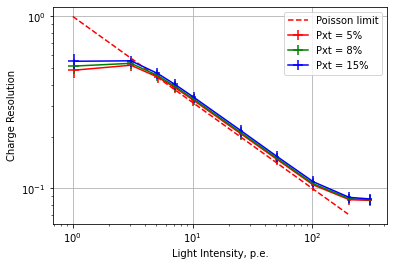

In [49]:
plt.errorbar(pe_mean[0], charge_resolution_mean[0], yerr = charge_resolution_std[0], xerr = pe_std[0], color = 'red', label='Pxt = 5%')
plt.errorbar(pe_mean[1], charge_resolution_mean[1], yerr = charge_resolution_std[1], xerr = pe_std[0], color = 'green', label='Pxt = 8%')
plt.errorbar(pe_mean[2], charge_resolution_mean[2], yerr = charge_resolution_std[2], xerr = pe_std[0], color = 'blue', label='Pxt = 15%')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Charge Resolution')
plt.grid(True)
plt.plot(pe_poisson, charge_resolution_poisson, "--r", label='Poisson limit')
plt.savefig('Charge_resolution_200_events.png', dpi=1800)
plt.legend()
plt.show()

In [41]:
pe_mean[0][1:]

[3.057052710654814,
 5.0989282584199325,
 7.135942156003506,
 10.182504069112309,
 25.474929260047578,
 50.93487667459622,
 101.86375109553023,
 203.76021284587455,
 305.76714786528106]

In [108]:
print(charge_resolution_list[0][0][0])
print(pe_true_list_mean[0][0][0])

print(charge_resolution_list[1][0][0])
print(pe_true_list_mean[1][0][0])

print(charge_resolution_list[2][0][0])
print(pe_true_list_mean[2][0][0])

0.38554209997790656
6.0
0.38554209997790656
6.0
0.38554209997790656
6.0


No handles with labels found to put in legend.


[0.4333154396169632, 0.5070584010568023, 0.1023837122639815, 0.0837700987240684, 0.44946566727066983, 0.14421089142974255, 0.2032443191814886, 0.3193458406564462, 0.3794030798679303, 0.08298976089309586, 0.4333154396169632, 0.5070584010568023, 0.1023837122639815, 0.0837700987240684, 0.44946566727066983, 0.14421089142974255, 0.2032443191814886, 0.3193458406564462, 0.3794030798679303, 0.08298976089309586, 0.4333154396169632, 0.5070584010568023, 0.1023837122639815, 0.0837700987240684, 0.44946566727066983, 0.14421089142974255, 0.2032443191814886, 0.3193458406564462, 0.3794030798679303, 0.08298976089309586]


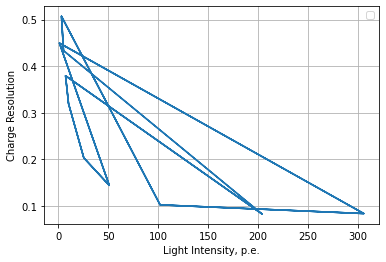

In [106]:
x = []
y = []

for i_xt in range(len(p_xt)):
    for item, i_file in enumerate(files):
        #print(p_xt[i_xt])
        x.append(np.mean(pe_true_list_mean[i_xt][item]) )
        y.append(np.mean(charge_resolution_list[i_xt][item]) )
        
plt.plot(x, y, "-")

print(y)

#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Charge Resolution')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for i_xt in range(len(p_xt)):
    print(i_xt)
    for item, i_file in enumerate(files):

        plt.plot(pe_true_map_mean[item], charge_resolution_list[item], ".", label='file number '+ str(item))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Charge Resolution')
plt.plot(pe_poisson, charge_resolution_poisson, "--r", label='Poisson limit')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
for item, i_file in enumerate(files):
    print(i_file)
    baseline_map[item], amplitude_map[item], waveform_map[item] = ana_waveforms(10, path[0]+str(p_xt[3]) + path[1] + i_file)

ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz


TraitError: Path "/mnt/yggdrasil_data/prod5/mono-lst-sipm-borofloat-3ns/pxt_0.25/light_emission/output/ff-1m_r_1nphot_10000000_dist_500_radius_150_event.simtel.gz" does not exist

In [36]:
baseline_map, amplitude_map, waveform_map = ana_waveforms(10, path[0]+str(p_xt[0]) + path[1] + files[6])

In [43]:
p_xt[3]

0.25

In [32]:
charge_resolution_poisson = []
pe_poisson = np.arange(1, 200, 1)

for i in range(len(pe_poisson)):
    charge_resolution_poisson.append(1./math.sqrt(pe_poisson[i]))

charge_resolution_poisson

[1.0,
 0.7071067811865475,
 0.5773502691896258,
 0.5,
 0.4472135954999579,
 0.4082482904638631,
 0.3779644730092272,
 0.35355339059327373,
 0.3333333333333333,
 0.31622776601683794,
 0.30151134457776363,
 0.2886751345948129,
 0.2773500981126146,
 0.2672612419124244,
 0.2581988897471611,
 0.25,
 0.24253562503633297,
 0.23570226039551587,
 0.22941573387056174,
 0.22360679774997896,
 0.2182178902359924,
 0.21320071635561041,
 0.20851441405707477,
 0.20412414523193154,
 0.2,
 0.19611613513818404,
 0.19245008972987526,
 0.1889822365046136,
 0.18569533817705186,
 0.18257418583505536,
 0.1796053020267749,
 0.17677669529663687,
 0.17407765595569785,
 0.17149858514250882,
 0.1690308509457033,
 0.16666666666666666,
 0.1643989873053573,
 0.16222142113076254,
 0.16012815380508713,
 0.15811388300841897,
 0.15617376188860607,
 0.1543033499620919,
 0.15249857033260467,
 0.15075567228888181,
 0.14907119849998599,
 0.14744195615489714,
 0.14586499149789456,
 0.14433756729740646,
 0.14285714285714285,
 

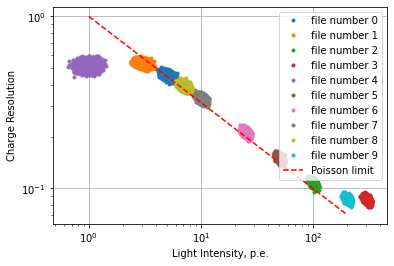

In [33]:
#print()

for item, i_file in enumerate(files):

    plt.plot(pe_true_map_mean[item], charge_resolution[item], ".", label='file number '+ str(item))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Charge Resolution')
plt.plot(pe_poisson, charge_resolution_poisson, "--r", label='Poisson limit')
plt.grid(True)
plt.legend()
plt.show()

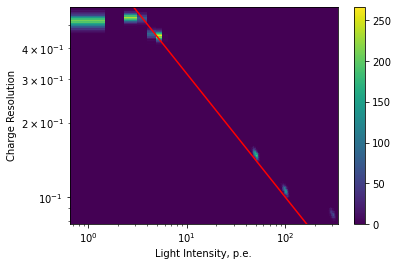

In [34]:
#plt.scatter(pe_true_map_mean[1], charge_resolution[1], alpha=1, cmap='viridis')
#plt.colorbar();
#plt.show()

plt.hist2d(pe_true_map_mean[0] + pe_true_map_mean[1] + pe_true_map_mean[2] + pe_true_map_mean[3] + pe_true_map_mean[4] + pe_true_map_mean[5], charge_resolution[0] + charge_resolution[1] + charge_resolution[2] + charge_resolution[3] + charge_resolution[4] + charge_resolution[5], bins=400)
#plt.hist2d(pe_true_map_mean[0], charge_resolution[0], bins=30, cmap='Blues', range=[[0.1, 150], [0.1, 1]])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Charge Resolution')
plt.colorbar()
plt.plot(pe_poisson, charge_resolution_poisson, "-r", label='Poisson limit')
#plt.savefig('charge_resolution_6intensity.png', dpi=800)
plt.show()